## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [41]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

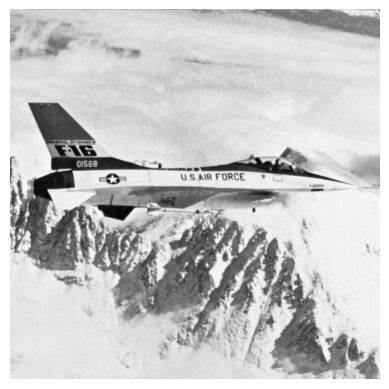

In [42]:
jet_img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)

plt.imshow(jet_img, 'gray')
plt.axis('off')

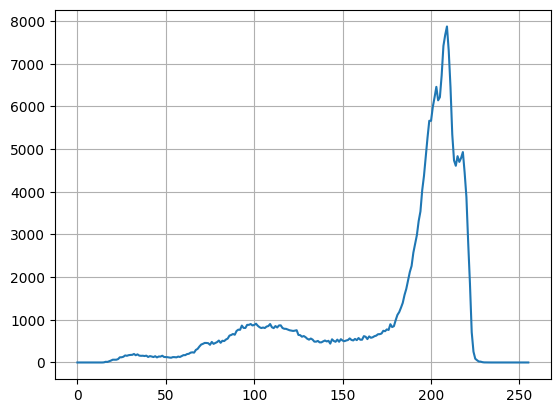

In [43]:
jet_hist = cv2.calcHist([jet_img], [0], None, [256], [0, 256])

plt.plot(jet_hist)
plt.grid()

In [44]:
bbhe_lm = np.astype(np.round(cv2.mean(jet_img)[0]), np.uint8)
dishe_lm = np.argmin(np.abs(np.cumsum(jet_hist) - 256*256/2))

In [45]:
H1_bbhe, H2_bbhe = jet_hist[:bbhe_lm], jet_hist[bbhe_lm:]
H1_dishe, H2_dishe = jet_hist[:dishe_lm], jet_hist[dishe_lm:]

In [46]:
C1_bbhe, C2_bbhe = np.cumsum(H1_bbhe), np.cumsum(H2_bbhe)
C1_dishe, C2_dishe = np.cumsum(H1_dishe), np.cumsum(H2_dishe)

In [47]:
C1_bbhe = C1_bbhe / C1_bbhe.max()
C2_bbhe = C2_bbhe / C2_bbhe.max()

C1_dishe = C1_dishe / C1_dishe.max()
C2_dishe = C2_dishe / C2_dishe.max()

In [55]:
C1n_bbhe, C2n_bbhe = np.round(C1_bbhe * bbhe_lm).astype(np.uint8), np.round(bbhe_lm + 1 + (255 - bbhe_lm - 1)*C2_bbhe).astype(np.uint8)
LUT_bbhe = np.append(C1n_bbhe, C2n_bbhe)

In [56]:
C1n_dishe, C2n_dishe = np.round(C1_dishe * dishe_lm).astype(np.uint8), np.round(dishe_lm + 1 + (255 - dishe_lm - 1)*C2_dishe).astype(np.uint8)
LUT_dishe = np.append(C1n_dishe, C2n_dishe)

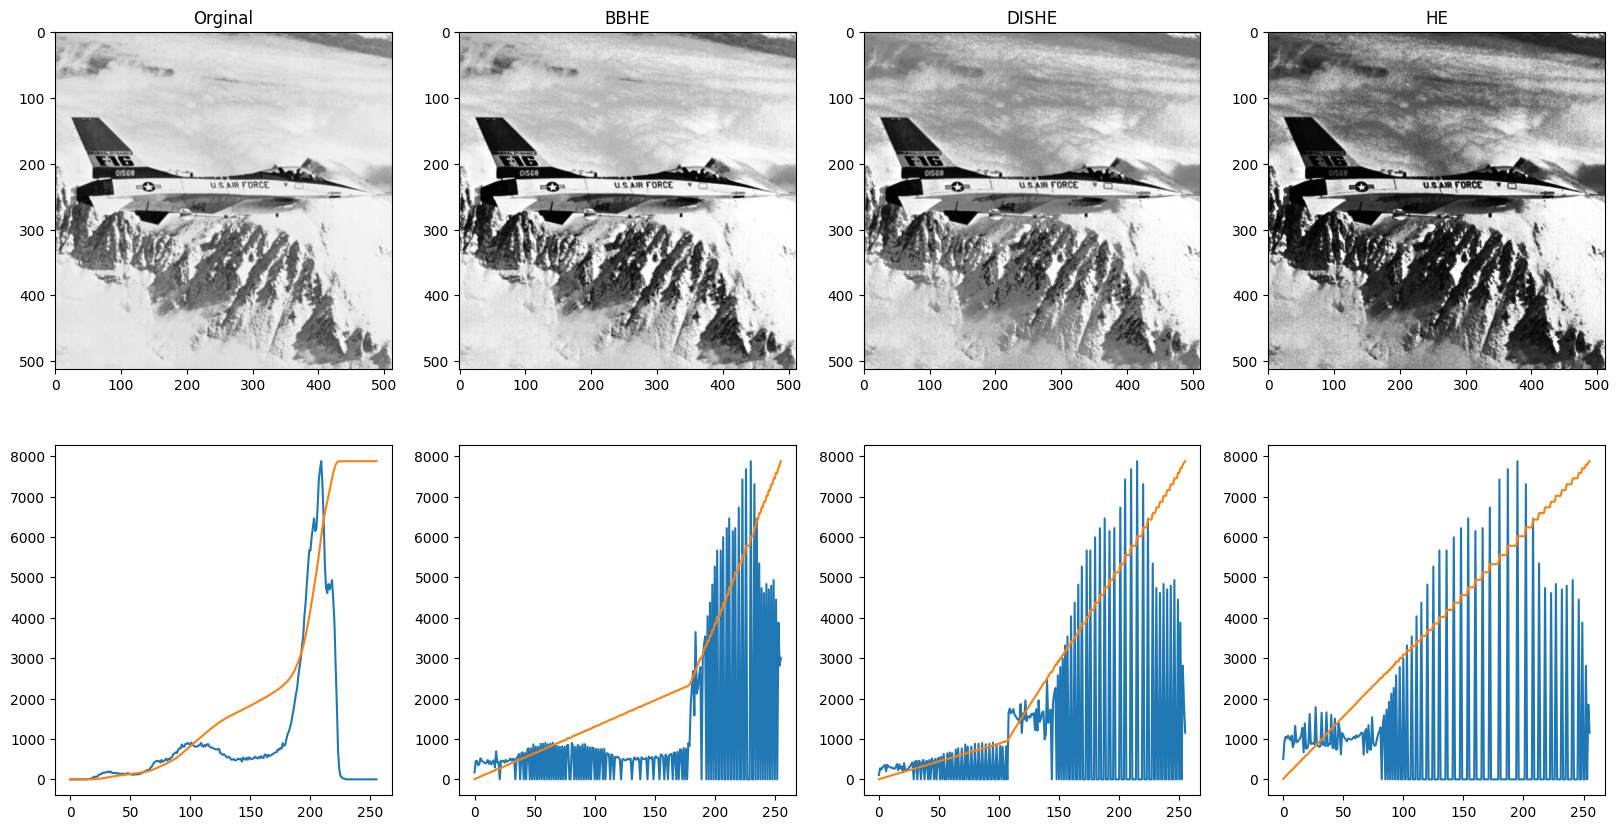

In [63]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].imshow(jet_img, 'gray')
axs[0, 0].set_title('Orginal')

hist1 = cv2.calcHist([jet_img], [0], None, [256], [0, 256])
hist1_cum = np.cumsum(hist1)
hist1_cum = hist1_cum * hist1.max() / hist1_cum.max()
axs[1, 0].plot(hist1)
axs[1, 0].plot(hist1_cum)

axs[0, 1].imshow(cv2.LUT(jet_img, LUT_bbhe), 'gray')
axs[0, 1].set_title('BBHE')

hist2 = cv2.calcHist([cv2.LUT(jet_img, LUT_bbhe)], [0], None, [256], [0, 256])
hist2_cum = np.cumsum(hist2)
hist2_cum = hist2_cum * hist2.max() / hist2_cum.max()
axs[1, 1].plot(hist2)
axs[1, 1].plot(hist2_cum)

axs[0, 2].imshow(cv2.LUT(jet_img, LUT_dishe), 'gray')
axs[0, 2].set_title('DISHE')

hist3 = cv2.calcHist([cv2.LUT(jet_img, LUT_dishe)], [0], None, [256], [0, 256])
hist3_cum = np.cumsum(hist3)
hist3_cum = hist3_cum * hist3.max() / hist3_cum.max()
axs[1, 2].plot(hist3)
axs[1, 2].plot(hist3_cum)

axs[0, 3].imshow(cv2.equalizeHist(jet_img), 'gray')
axs[0, 3].set_title('HE')

hist4 = cv2.calcHist([cv2.equalizeHist(jet_img)], [0], None, [256], [0, 256])
hist4_cum = np.cumsum(hist4)
hist4_cum = hist4_cum * hist4.max() / hist4_cum.max()
axs[1, 3].plot(hist4)
axs[1, 3].plot(hist4_cum)